In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import zipfile
import os
import random
import scipy.io.arff as arff


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
zip_path = '/content/drive/My Drive/Datasets/EEG_Eye_State.zip'
extract_path = '/content/eeg_eye_state_data'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [ ]:
def load_eeg_eye_state_data(path):
    data, meta = arff.loadarff(os.path.join(path, 'EEG Eye State.arff'))
    df = pd.DataFrame(data)

    # Son kolonu etiket olarak ayırma
    signals = df.iloc[:, :-1].values
    labels = df.iloc[:, -1].astype(int).values  # Etiketleri integer olarak ayarlama

    return signals, labels

path = extract_path
eeg_signals, labels = load_eeg_eye_state_data(path)

# Etiketlerin benzersiz değerlerini ve sınıf sayısını belirleyeme
unique_labels = np.unique(labels)
n_classes = len(unique_labels)

print(f"Etiketlerin benzersiz değerleri: {unique_labels}")
print(f"Toplam sınıf sayısı: {n_classes}")


Etiketlerin benzersiz değerleri: [0 1]
Toplam sınıf sayısı: 2


In [ ]:
if eeg_signals.size != 0 and labels.size != 0:
    # Verileri ölçekleme
    scaler = StandardScaler()
    eeg_signals_scaled = scaler.fit_transform(eeg_signals)

    # Eğitim ve test setlerine bölme
    X_train, X_test, y_train, y_test = train_test_split(eeg_signals_scaled, labels, test_size=0.2, random_state=42)


In [ ]:
# Eğitim ve test setlerine bölme
X_train, X_test, y_train, y_test = train_test_split(eeg_signals_scaled, labels, test_size=0.2, random_state=42)

# Eğitim ve test setlerindeki örnek sayılarını yazdırma
print(f"Eğitim için kullanılan örnek sayısı: {X_train.shape[0]}")
print(f"Test için kullanılan örnek sayısı: {X_test.shape[0]}")

# LSTM modeline uygun hale getirme işlemi
n_timesteps = 100  # Zaman adımı
n_features = eeg_signals.shape[1]  # Özellik sayısı

def create_sequences(data, labels, n_timesteps):
    sequences = []
    for i in range(len(data) - n_timesteps):
        sequence = data[i:i+n_timesteps]
        label = labels[i+n_timesteps-1]
        sequences.append((sequence, label))
    X, y = zip(*sequences)
    return np.array(X), np.array(y)

X_train_seq, y_train_seq = create_sequences(X_train, y_train, n_timesteps)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, n_timesteps)

# Etiketleri one-hot encoding ile dönüştürme
y_train_seq = tf.keras.utils.to_categorical(y_train_seq, num_classes=n_classes)
y_test_seq = tf.keras.utils.to_categorical(y_test_seq, num_classes=n_classes)


Eğitim için kullanılan örnek sayısı: 11984
Test için kullanılan örnek sayısı: 2996


In [ ]:
model = Sequential()
model.add(LSTM(100, input_shape=(n_timesteps, n_features)))
model.add(Dense(n_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
history = model.fit(X_train_seq, y_train_seq, epochs=30, batch_size=64, validation_split=0.2)


Epoch 1/30
149/149 [==============================] - 29s 194ms/step - loss: 0.6294 - accuracy: 0.6253 - val_loss: 0.6288 - val_accuracy: 0.6184
Epoch 2/30
149/149 [==============================] - 22s 145ms/step - loss: 0.6168 - accuracy: 0.6372 - val_loss: 0.6269 - val_accuracy: 0.6201
Epoch 3/30
149/149 [==============================] - 23s 155ms/step - loss: 0.6121 - accuracy: 0.6422 - val_loss: 0.6244 - val_accuracy: 0.6218
Epoch 4/30
149/149 [==============================] - 22s 146ms/step - loss: 0.6073 - accuracy: 0.6430 - val_loss: 0.6264 - val_accuracy: 0.6252
Epoch 5/30
149/149 [==============================] - 22s 146ms/step - loss: 0.6030 - accuracy: 0.6530 - val_loss: 0.6234 - val_accuracy: 0.6281
Epoch 6/30
149/149 [==============================] - 22s 149ms/step - loss: 0.5973 - accuracy: 0.6621 - val_loss: 0.6296 - val_accuracy: 0.6205
Epoch 7/30
149/149 [==============================] - 21s 139ms/step - loss: 0.5921 - accuracy: 0.6656 - val_loss: 0.6275 - val_ac

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               46000     
                                                                 
 dense (Dense)               (None, 2)                 202       
                                                                 
Total params: 46202 (180.48 KB)
Trainable params: 46202 (180.48 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
91/91 [==============================] - 3s 24ms/step


<Figure size 1600x1200 with 0 Axes>

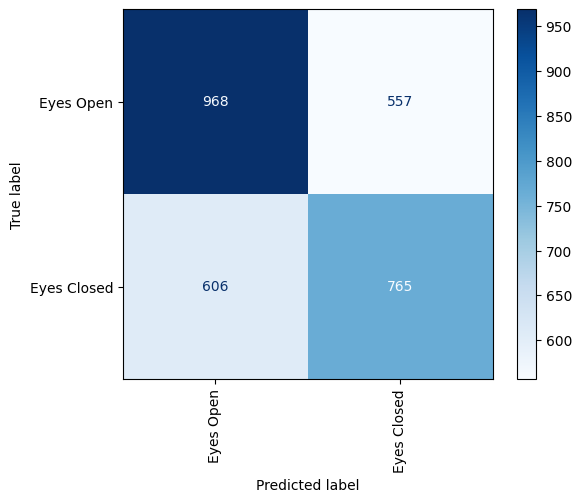

In [ ]:
model.summary()

# Karışıklık matrisi oluşturma ve görselleştirme
y_pred = model.predict(X_test_seq)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_seq, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Eyes Open', 'Eyes Closed'])

# Daha büyük bir figür boyutu ayarlama
plt.figure(figsize=(16, 12))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.show()


1/1 [==============================] - 0s 35ms/step
Gerçek Sınıf: 1 (Eyes Closed)
Tahmin Edilen Sınıf: 0 (Eyes Open)


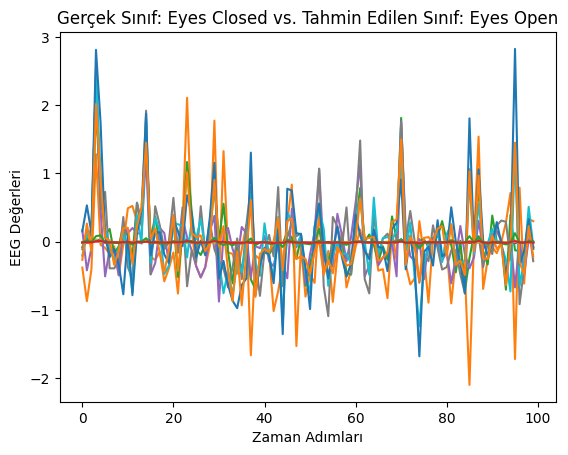

In [ ]:
random_index = random.randint(0, X_test_seq.shape[0] - 1)
random_sample = X_test_seq[random_index]
random_sample_reshaped = random_sample.reshape(1, n_timesteps, n_features)

predicted_class = np.argmax(model.predict(random_sample_reshaped), axis=1)[0]
true_class = np.argmax(y_test_seq[random_index])

print(f"Gerçek Sınıf: {true_class} ({disp.display_labels[true_class]})")
print(f"Tahmin Edilen Sınıf: {predicted_class} ({disp.display_labels[predicted_class]})")

# Rastgele örnek verinin görselleştirilmesi
plt.plot(random_sample)
plt.title(f"Gerçek Sınıf: {disp.display_labels[true_class]} vs. Tahmin Edilen Sınıf: {disp.display_labels[predicted_class]}")
plt.xlabel("Zaman Adımları")
plt.ylabel("EEG Değerleri")
plt.show()


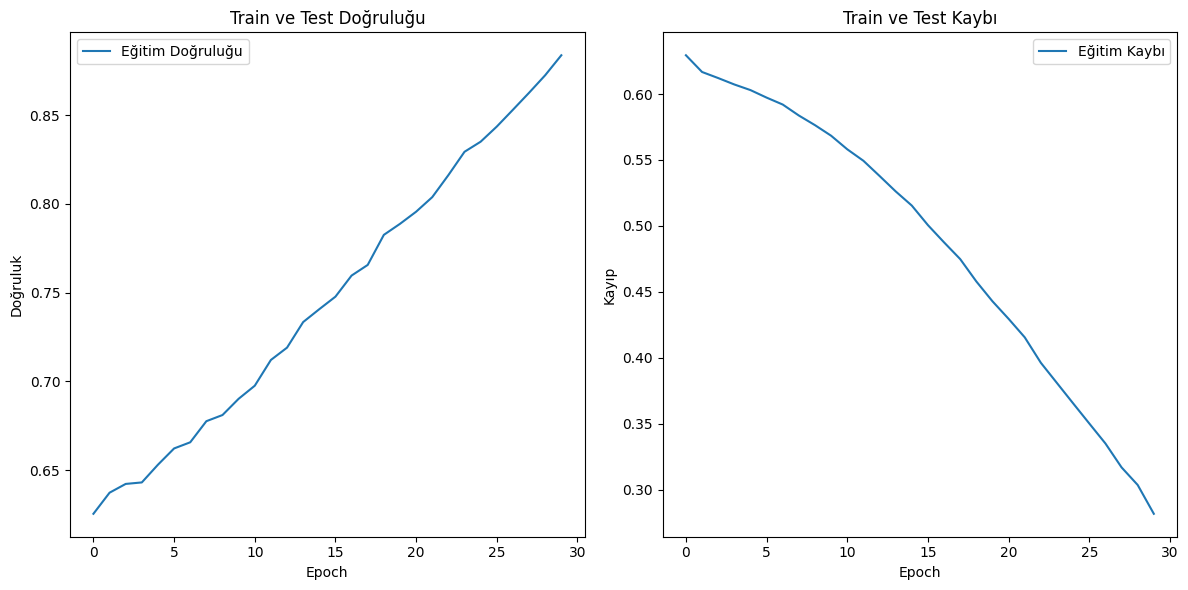

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')

plt.title('Train ve Test Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

# Kayıp değerlerini görselleştirme
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')

plt.title('Train ve Test Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

plt.tight_layout()
plt.show()
